In [54]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.utils import to_categorical

## 문제 3

아래의 데이터셋은 이탈리아의 한 지방에서 생상되는 와인 3종류의 성분을 화학 분석한 데이터셋이다.

> https://data.hossam.kr/F03/wine_3type.xlsx

종속변수인 와인의 종류는 `kind`라는 이름의 변수에 저장되어 있으며 그 외의 변수들은 화학적 성분을 의미한다.

이 데이터를 활용하여 와인의 종류를 분류할 수 있는 모델을 구현하라.

적용해야 하는 분석모델의 종류는 데이터의 형태에 따라 스스로 결정해야 합니다.

In [55]:
origin = read_excel('https://data.hossam.kr/F03/wine_3type.xlsx')
origin.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,kind
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,class_0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,class_0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,class_0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,class_0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,class_0


In [56]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    int64  
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    int64  
 13  kind 

In [57]:
origin.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
kind                            0
dtype: int64

원핫인코딩 / 다항분류(시그모이드는 2항문류, 소프트맥스는 다항분류) kind를 라벨화 해야함

In [58]:
# 명목형 변수 형변환 -> 미리 카테고리 타입으로 바꿔야, 매번 필터를 걸지 않는다.
origin['kind'] = origin['kind'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   alcohol                       178 non-null    float64 
 1   malic_acid                    178 non-null    float64 
 2   ash                           178 non-null    float64 
 3   alcalinity_of_ash             178 non-null    float64 
 4   magnesium                     178 non-null    int64   
 5   total_phenols                 178 non-null    float64 
 6   flavanoids                    178 non-null    float64 
 7   nonflavanoid_phenols          178 non-null    float64 
 8   proanthocyanins               178 non-null    float64 
 9   color_intensity               178 non-null    float64 
 10  hue                           178 non-null    float64 
 11  od280/od315_of_diluted_wines  178 non-null    float64 
 12  proline                       178 non-null    int6

## # 탐색적 데이터 분석

In [59]:
origin.describe()

# 평균이 들쭉날쭉 하면 표준화 

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


데이터분포가 상이하므로 표준화가 필요하다고 판단

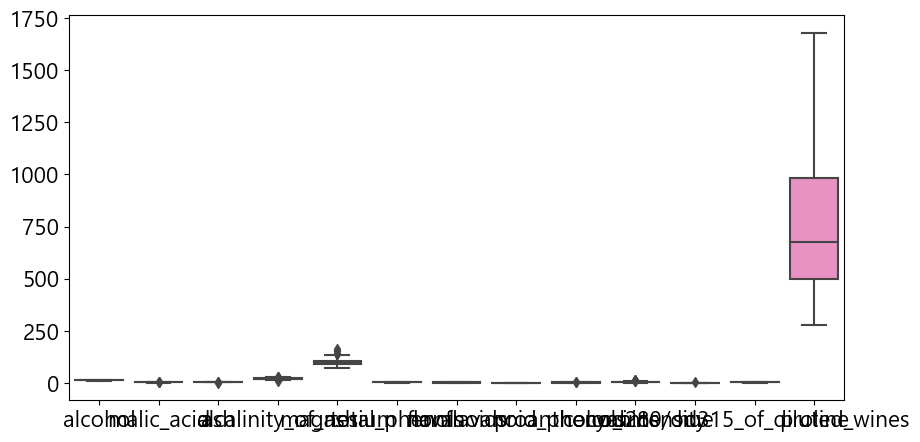

In [60]:
# 회귀가 아니라서 산점도는 필요없고, 상자그림만 확인 
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.show()
plt.close()

In [61]:
np.random.seed(777)

In [62]:
# 훈련데이터와 레이블 구분
y = origin[['kind']]
x = origin.drop('kind',axis=1)
x.shape, y.shape

((178, 13), (178, 1))

In [70]:
# y값 확인
y.value_counts()

kind   
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64

In [ ]:
y['kind']

In [68]:
# 다항분류이므로 원핫인코딩 처리가 들어간다

y_cate = to_categorical(y['kind'])
y_cate

# ValueError: invalid literal for int() with base 10: 'class_0' 

# 수정 
y_cate = to_categorical(y['kind'])
y_cate


ValueError: invalid literal for int() with base 10: 'class_0'

In [64]:
# 데이터 표준화
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
x_scale_df = DataFrame(x_scale,columns=x.columns, index=x.index)

x_scale_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [65]:
# 훈련데이터와 검증 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((124, 13), (54, 13), (124, 1), (54, 1))

In [66]:
# 모델 정의
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(x_train.columns), )))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                448       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
# 학습하기
# result = model.fit(x_train,y_train,epochs=500,validation_batch = (x_test,y_test))


result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500


UnimplementedError: Graph execution error:

Detected at node 'binary_crossentropy/Cast' defined at (most recent call last):
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MegaIT302-02\AppData\Local\Temp\ipykernel_8964\3643668589.py", line 5, in <module>
      result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\MegaIT302-02\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 2421, in binary_crossentropy
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'binary_crossentropy/Cast'
Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_1415]

정확도가 높으면 손실률은 안봐도 된다.

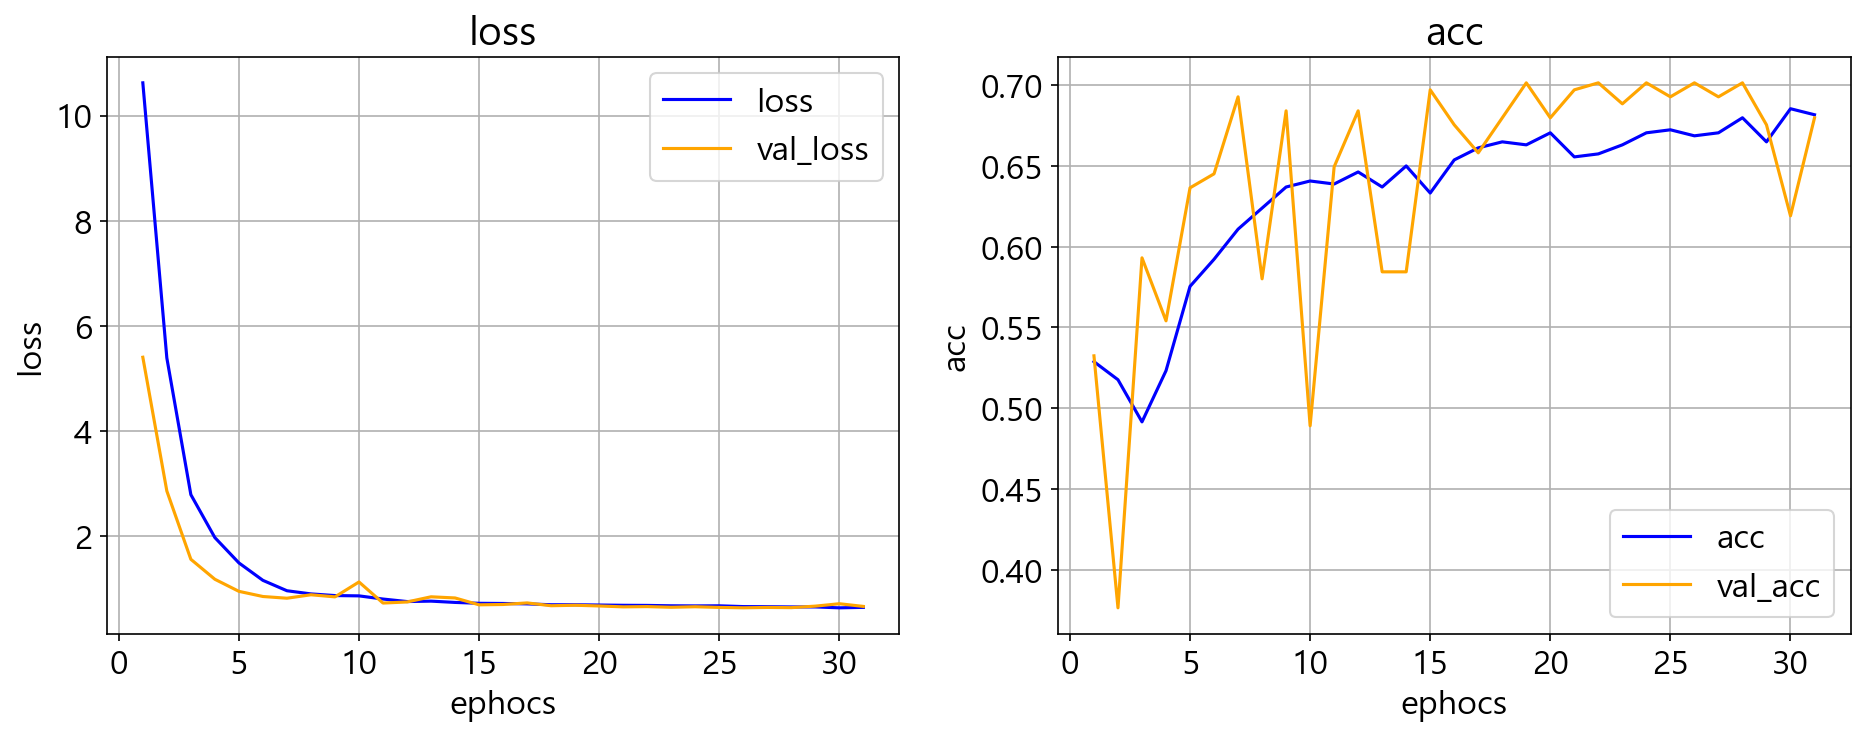

17/17 [==============================] - 0s 976us/step - loss: 0.6418 - acc: 0.6797
최종 훈련 손실률: 0.641768, 최종 훈련 정확도: 0.679702
8/8 [==============================] - 0s 0s/step - loss: 0.6684 - acc: 0.6797
최종 검증 손실률: 0.668429, 최종 검증 정확도: 0.679654


In [ ]:
# 학습결과 평가

helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

In [ ]:
# 테스트 데이터에 대한 예측 결과 산정
train_pred = model.predict(x_train)
data_count, case_count = train_pred.shape
print(data_count,'개의 훈련 데이터가 ',case_count,'개의 경우의 수를 갖는다.')
train_pred

# 50%보다 작으면 0, 크면 1로 



17/17 [==============================] - 0s 745us/step
537 개의 훈련 데이터가  1 개의 경우의 수를 갖는다.


array([[8.37044477e-01],
       [6.26429856e-01],
       [4.65012968e-01],
       [7.60786355e-01],
       [4.83523041e-01],
       [7.30890632e-02],
       [1.89120263e-01],
       [8.06978226e-01],
       [6.22508585e-01],
       [1.50260210e-01],
       [6.89905226e-01],
       [1.21964648e-01],
       [5.78941464e-01],
       [1.09626837e-02],
       [7.02447474e-01],
       [3.59320998e-01],
       [3.18738461e-01],
       [6.11482918e-01],
       [1.52776271e-01],
       [2.15462506e-01],
       [1.87187746e-01],
       [8.80987704e-01],
       [4.29948092e-01],
       [5.62661767e-01],
       [6.02273941e-01],
       [2.56255299e-01],
       [3.18297565e-01],
       [4.00584843e-03],
       [7.76936769e-01],
       [2.94755399e-01],
       [6.12455644e-02],
       [1.63856551e-01],
       [1.40913829e-01],
       [1.85891986e-01],
       [5.75726330e-01],
       [4.26739961e-01],
       [9.12241340e-02],
       [4.19101208e-01],
       [7.37721980e-01],
       [1.65242583e-01],


In [ ]:
train_df = DataFrame({
    '관측치': y_train['class'],
    '예측치': np.round(train_pred.flatten())
})

train_df

NameError: name 'y_train' is not defined

In [ ]:
# 검증 데이터에 대한 예측 결과 산정
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(test_pred)

8/8 [==============================] - 0s 687us/step
231개의 검증 데이터가 1개의 경우의 수를 갖는다.
[[8.04946348e-02]
 [2.61127174e-01]
 [3.59012693e-01]
 [3.11758667e-01]
 [8.80775273e-01]
 [5.96416950e-01]
 [9.43926513e-01]
 [3.09828877e-01]
 [8.52253199e-01]
 [6.16191804e-01]
 [3.82225215e-02]
 [6.28001839e-02]
 [2.51728892e-01]
 [1.50721803e-01]
 [1.05193339e-01]
 [2.97924057e-02]
 [3.70242521e-02]
 [1.68618545e-01]
 [9.51229393e-01]
 [3.40279937e-02]
 [5.54921553e-02]
 [2.23874867e-01]
 [9.13457036e-01]
 [6.78310931e-01]
 [2.39273265e-01]
 [5.08757710e-01]
 [3.89032722e-01]
 [7.59467840e-01]
 [4.50411439e-01]
 [3.57369334e-01]
 [1.34399906e-01]
 [1.91545382e-01]
 [7.51585737e-02]
 [1.20992344e-02]
 [4.56018478e-01]
 [1.71524333e-03]
 [6.57386631e-02]
 [4.80440289e-01]
 [4.12925452e-01]
 [3.72330457e-01]
 [2.02200904e-01]
 [8.07806194e-01]
 [2.24520698e-01]
 [7.41417229e-01]
 [2.87446797e-01]
 [4.66029420e-02]
 [1.15350420e-02]
 [2.49983706e-02]
 [2.03620698e-02]
 [3.45390707e-01]
 [7.40243137e-01]

In [ ]:
test_df = DataFrame({
    '관측치': y_train['Outcome'],
    '예측치': np.round(train_pred.flatten())
})

test_df

KeyError: 'Outcome'

In [ ]:
# 결과 확인
logit = helper.tf_logit_result(model, result, x_train, y_train)
logit

In [ ]:
logit.cmdf

In [ ]:
logit.result_df.T

In [ ]:
logit.odds_rate_df

In [ ]:
# 결과 확인
# 왜 결과를 우리가 헬퍼로 학인해야 하나요... 


# 의학 모델은 정확도가 더 엄격하여 95% 이상을 목표로 한다.
